In [78]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import os
from cleaning_utils import *
import numpy as np

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
def lines_to_words(lines):
    words = []
    for line in lines:
        for word in str(line).split():
            words.append(word)
    return words

In [6]:
cwd = os.getcwd()
cwd
df = pd.read_csv(os.path.join(cwd, "MetObjects.txt"))

/var/folders/gw/nk95rbjx5zq50kh26yn5q0mr0000gn/T/ipykernel_27493/2083818590.py:3: DtypeWarning: Columns (5,7,10,11,12,13,14,34,35,36,37,38,39,40,41,42,43,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(cwd, "MetObjects.txt"))


In [7]:
peter_col_list = [i for i in range(1, df.shape[1], 3)]
peter_df = df.iloc[:, peter_col_list]
peter_df = peter_df.astype(str, errors="ignore")


In [12]:
peter_df.head(10)


,Is Highlight,Object ID,AccessionYear,Culture,Reign,Artist Role,Artist Display Bio,Artist Nationality,Artist Gender,Object Date,Medium,Geography Type,County,Subregion,Excavation,Rights and Reproduction,Metadata Date,Tags AAT URL
0,False,1,1979.0,nan,nan,Maker,"American, Delaware County, Pennsylvania 1794–1...",American,nan,1853,Gold,nan,nan,nan,nan,nan,nan,nan
1,False,2,1980.0,nan,nan,Maker,1785–1844,,nan,1901,Gold,nan,nan,nan,nan,nan,nan,nan
2,False,3,1967.0,nan,nan,nan,nan,nan,nan,1909–27,Gold,nan,nan,nan,nan,nan,nan,nan
3,False,4,1967.0,nan,nan,nan,nan,nan,nan,1909–27,Gold,nan,nan,nan,nan,nan,nan,nan
4,False,5,1967.0,nan,nan,nan,nan,nan,nan,1909–27,Gold,nan,nan,nan,nan,nan,nan,nan
5,False,6,1967.0,nan,nan,nan,nan,nan,nan,1909–27,Gold,nan,nan,nan,nan,nan,nan,nan
6,False,7,1967.0,nan,nan,nan,nan,nan,nan,1909–27,Gold,nan,nan,nan,nan,nan,nan,http://vocab.getty.edu/page/aat/300266506|http...
7,False,8,1967.0,nan,nan,nan,nan,nan,nan,1909–27,Gold,nan,nan,nan,nan,nan,nan,http://vocab.getty.edu/page/aat/300250049|http...
8,False,9,1967.0,nan,nan,nan,nan,nan,nan,1909–27,Gold,nan,nan,nan,nan,nan,nan,nan
9,False,10,1979.0,nan,nan,Maker,1867–1917,,nan,1912,Gold,nan,nan,nan,nan,nan,nan,nan


In [8]:
pd.DataFrame(peter_df.columns)

,0
0,Is Highlight
1,Object ID
2,AccessionYear
3,Culture
4,Reign
5,Artist Role
6,Artist Display Bio
7,Artist Nationality
8,Artist Gender
9,Object Date


In [ ]:
for col in peter_df.columns:
    unique_values = peter_df[col].unique()
    print('---------')
    print(col,unique_values)

In [19]:
df_clean = df.copy()

# Column Types / Range / Cleaning Tasks
#### Is Highlight 
- bool
- True/False only 
- No cleanup, ok as-is
#### Object ID
- int64
- 1 through 860873
- No cleanup, ok as-is


#### AccessionYear
- 4 digit year
- Ex: nan, 1889.0, 1928, 19171917.0, 1956-08-24
- Clean: keep only first 4 digits will fix all 4 issues

In [111]:
df_clean['AccessionYear'] = df_clean['AccessionYear'].str[:4]
#df_clean['AccessionYear'].dropna()


<AxesSubplot:xlabel='AccessionYear'>

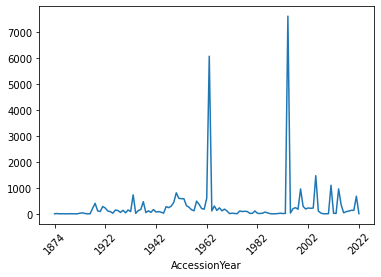

In [110]:
# plot accession years
counts = df_clean['AccessionYear'].dropna().groupby([df['AccessionYear']]).count()
# counts.sort_values()
counts.plot(rot=45)

#### Culture
- category
- Ex: nan, 'reign of Amenhotep III', 'reign of  Xerxes I'
- remove duplicate spaces
- possibly remove 'reign of', 'reigns of', 'or later', 'possibly', 'or slightly later', ',early', ',probably', (anything after comma), (anything in parens), (question marks), (space at end), (split on slash,dash/'and'/'or' and process individually), 'to xyz' and group by remaining names

In [100]:
df_clean['Culture'].astype(str)
df_clean['Culture'].replace('reign. of', '', regex=True, inplace=True)
df_clean['Culture'].replace('or.*later', '', regex=True, inplace=True)
df_clean['Culture'].replace('early', '', regex=False, inplace=True)
df_clean['Culture'].replace('or', '', regex=False, inplace=True)
df_clean['Culture'].replace('probably', '', regex=False, inplace=True)
df_clean['Culture'].replace('possibly', '', regex=False, inplace=True)
df_clean['Culture'].replace('Possibly', '', regex=False, inplace=True)
df_clean['Culture'].replace(';', '', regex=False, inplace=True)
df_clean['Culture'].replace('\(.*\)', '', regex=True, inplace=True)
df_clean['Culture'].replace('\?', '', regex=True, inplace=True)
df_clean['Culture'] = df_clean['Culture'].dropna().str.strip()
df_clean['Culture'] = df_clean['Culture'].dropna().str.lower()
# for culture in df_clean['Culture'].unique():
#     print(culture)


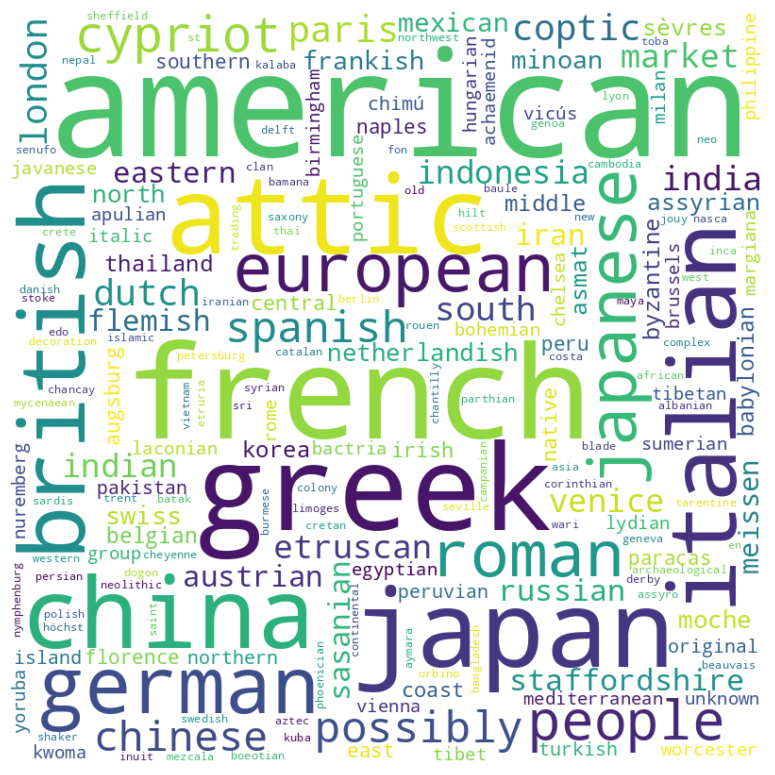

In [99]:
# generate a WordCloud for "Culture"

stopwords = set(STOPWORDS)

word_list = lines_to_words(df_clean['Culture'].dropna().tolist())

for i in range(len(word_list)):
    word_list[i] = word_list[i].lower()

word_string = ''
word_string += " ".join(word_list)+" "

wordcloud = WordCloud(collocations=False, width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=10).generate(word_string)
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# plt.tight_layout(pad=0)
plt.show()

#### Artist Role
- object
- Ex: 'nan', 'Maker', 'Designer|Manufacturer'
- Clean: split on vert bar?

<AxesSubplot:xlabel='Artist Role'>

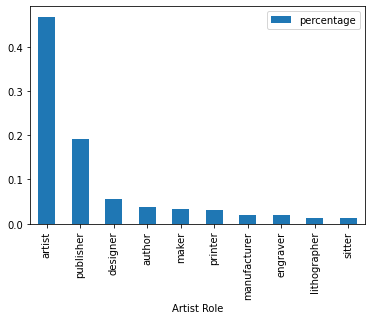

In [148]:
artist_roles = lines_to_words(df_clean['Artist Role'].dropna().tolist())
artist_roles_clean = []
for i in range(len(artist_roles)):
    artist_roles_clean.extend(artist_roles[i].lower().split('|'))

artist_roles_df = pd.DataFrame(artist_roles_clean, columns=['Artist Role'])

#calculate sum of values by group
df_groups = artist_roles_df.groupby(['Artist Role'])['Artist Role'].sum()

artist_roles_df = artist_roles_df['Artist Role'].dropna().groupby([artist_roles_df['Artist Role']]).count().reset_index(name='counts')
artist_roles_df['percentage'] = artist_roles_df['counts'] / artist_roles_df['counts'].sum()
top10 = artist_roles_df.sort_values(by='counts', ascending=False).head(10)
top10.plot.bar(x='Artist Role',y='percentage', rot=90)

#### Artist Display Bio
- object
- Ex: '1785–1844', 'nan', 'British, London 1873–1952 Hailsham, Sussex|British, Wiltshire 1877–1952 Oxford', '||||Female|Female'
- Issues: not sure what the vert bars separate
- None - don't use or use as-is

#### Object Date
- Numeric
- Ex: '1853', '1901', '1909–27', '1782-1784', 'December 1, 1925', 'after 1773'
- Clean: select first 4 digit number

In [161]:
df_clean['Object Date'] = df_clean['Object Date'].str.extract('([0-9]{4})')
object_dates_df = df_clean['Object Date'].dropna().groupby([df_clean['Object Date']]).count().reset_index(name='count').sort_values
# object_dates_df
object_dates_df['Object Date'].plot(kind='line',x='Object Date', y='count')

TypeError: sort_values() missing 1 required positional argument: 'by'


#### Medium
- object
- Ex: 'Gold' 'Silver' 'Bronze or copper' ...
 'Overlay  for 23.112.2889,  graphite and ink on glazed linen tracing paper'
 - Don't use or use as-is
 #### Geography Type
 - object
 - Ex: 'nan' 'Made in' 'Probably made in' 'Possibly made in|Possibly made in'
 'Made in|Probably made in' 'Possibly made in' 'Made in|Made in'
 'Probably made in|Possibly made in' '(none assigned)'
 'Made in|Possibly made in' 'Made in|Probably made in|Probably made in'
 'Made in|Object place' 'Made in|(none assigned)'
 'Possibly made in|Possibly made in|Possibly made in'
 'Possibly made in|Probably made in'
 - Issues: not sure why multiple entries
 #### County
 - object
 - Ex: 'nan' 'Staffordshire' 'Bristol' ... 'Rhode Island' 
 - Clean: Could group/count words
 #### Subregion
 - object
 - Ex: 'Borsippa (Birs Nimrud)' 'probably from Sippar (modern Tell Abu Habba)'
 'Nimrud (ancient Kalhu)' 'Sippar (?) (modern Tell Abu Habba)'
 - Clean: could group and count words, drop probably, from, to, be, etc.. (maybe join with County)
 #### Excavation
 - object
 - Ex: 'nan' 'Egyptian Antiquities Service excavations, 1891'
 'Barsanti excavations, 1903' 'Carnarvon/Carter excavations, 1910'
 - Clean: maybe pull and group 4-digit dates
#### Rights and Reproduction
- object
- Ex: 'nan' '© 2022 Artists Rights Society (ARS), New York' '© Tao Lengyue' ... '© Kim Hyunju' '© Kim Seol' '© Sohn Daehyun'
- Clean: ???
#### Metadata Date
- empty
- Ex: 'nan' (for all records)
- Clean: none
#### Tags AAT URL
- object
- Ex: 'http://vocab.getty.edu/page/aat/300266506|http://vocab.getty.edu/page/aat/300037222'
 'http://vocab.getty.edu/page/aat/300250049|http://vocab.getty.edu/page/aat/300025928|http://vocab.getty.edu/page/aat/300123319'
 - Issues: TMI - don't use

In [ ]:
# set data types
df['Is Highlight'].astype(bool)
df['Object ID'].astype(int64)
df['AccessionYear'].astype()
df['Culture'].astype()
df['Reign'].astype()
df['Artist Role'].astype()
df['Artist Display Bio'].astype()
df['Artist Nationality'].astype()
df['Artist Gender'].astype()
df['Object Date'].astype()
df['Medium'].astype()
df['Geography Type'].astype()
df['County'].astype()
df['Subregion'].astype()
df['Excavation'].astype()
df['Rights and Reproduction'].astype()
df['Metadata Date'].astype()
df['Tags AAT URL'].astype()